In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [62]:
# Load the data
df = pd.read_csv('final_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M')
df.set_index('datetime', inplace=True)

In [63]:
# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [64]:
# Create lag features
for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']:
    df[f'{target}_lag_1'] = df[target].shift(1)
    df[f'{target}_lag_24'] = df[target].shift(24)

In [65]:
# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

In [66]:
# Prepare features and target variables
categorical_features = ['weekday', 'hour', 'day_of_week', 'month', 'is_weekend']
numerical_features = ['temperature', 'humidity', 'wind_speed', 'precipitation'] + [f'{target}_lag_1' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']] + [f'{target}_lag_24' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']]
features = numerical_features + categorical_features
targets = ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']

In [67]:
# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [68]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

In [69]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [70]:
# Fit and transform the features
X = preprocessor.fit_transform(df)

In [71]:
# Normalize the target variables separately
y = np.zeros_like(df[targets].values)
scalers_y = {}
for i, target in enumerate(targets):
    scaler = StandardScaler()
    y[:, i] = scaler.fit_transform(df[[target]]).ravel()
    scalers_y[target] = scaler

In [72]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Reshape input data for GRU (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [74]:
# Build the improved GRU model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(256, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(targets))
])

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [75]:

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_split=0.2, 
                    verbose=1, callbacks=[early_stopping, lr_reducer])

Epoch 1/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 2.5506 - val_loss: 1.3165 - learning_rate: 0.0010
Epoch 2/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1236 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 3/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.8428 - val_loss: 0.8001 - learning_rate: 0.0010
Epoch 4/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.7026 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 5/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.6138 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 6/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5593 - val_loss: 0.3942 - learning_rate: 0.0010
Epoch 7/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.5043 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 8/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4690 - val_loss: 0.3415 - learning_rate: 0.0010
Epoch 9/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.4399 - val_loss: 0.3135 - learning_rate

In [76]:
# Make predictions
y_pred = model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


In [19]:
# Inverse transform the predictions and actual values
y_test_inv = np.zeros_like(y_test)
y_pred_inv = np.zeros_like(y_pred)
for i, target in enumerate(targets):
    y_test_inv[:, i] = scalers_y[target].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
    y_pred_inv[:, i] = scalers_y[target].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

In [20]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [21]:
for i, target in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    #mape = mean_absolute_percentage_error(y_test_inv[:, i], y_pred_inv[:, i]) * 100
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    mape = mean_absolute_percentage_error(y_test_inv[:, i], y_pred_inv[:, i])
    
    print(f"{target}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R2: {r2:.2f}")
    print()

DELHI:
  RMSE: 145.35
  MAPE: 2.73%
  R2: 0.99

BRPL:
  RMSE: 74.48
  MAPE: 3.33%
  R2: 0.98

BYPL:
  RMSE: 40.22
  MAPE: 4.02%
  R2: 0.98

NDMC:
  RMSE: 10.05
  MAPE: 4.30%
  R2: 0.98

MES:
  RMSE: 1.70
  MAPE: 3.74%
  R2: 0.96



In [31]:
y_pred

array([[-0.63213766, -0.63970715, -0.66048044, -0.4281063 , -0.17215951],
       [ 1.4461902 ,  1.3365083 ,  1.3006241 ,  2.2233071 ,  2.0382967 ],
       [ 0.6137509 ,  0.6066703 ,  0.66914743,  0.370955  , -0.02858217],
       ...,
       [ 0.7415265 ,  0.6051335 ,  0.673331  ,  1.6639903 ,  0.98048466],
       [-0.5609019 , -0.5660204 , -0.50143856, -0.62324464, -0.929498  ],
       [ 1.4961723 ,  1.3520919 ,  1.4017398 ,  2.3266585 ,  1.5806532 ]],
      dtype=float32)

In [48]:
y_pred_inv

array([[3285.4934  , 1364.2369  ,  682.71136 ,  148.84998 ,   26.950632],
       [6105.796   , 2564.4631  , 1303.6077  ,  321.2704  ,   46.295452],
       [4976.171   , 2121.2065  , 1103.6787  ,  200.81262 ,   28.20715 ],
       ...,
       [5149.5635  , 2120.2732  , 1105.0033  ,  284.89822 ,   37.038002],
       [3382.161   , 1408.9895  ,  733.0649  ,  136.1602  ,   20.322779],
       [6173.622   , 2573.9277  , 1335.6215  ,  327.99127 ,   42.290382]],
      dtype=float32)

In [49]:
train_predictions = y_pred_inv
train_predictions =scaler.inverse_transform(train_predictions)

actual = scaler.inverse_transform(y_test)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()

print(len(train_predictions))
print(len(actual))
print(len(train_results))

2203
2203
2203


In [50]:
train_results["Actuals"] = actual.tolist()

train_results

,Train Predictions,Actuals
0,"[4784.73095703125, 1988.1295166015625, 996.093...","[1.1920254103205223, 1.0029439238286966, 1.503..."
1,"[8889.9931640625, 3735.191650390625, 1899.8769...","[4.632927066478233, 4.437916026249974, 4.56132..."
2,"[7245.69970703125, 3089.982666015625, 1608.858...","[3.2311378360323575, 3.244088260455206, 3.4510..."
3,"[5029.71044921875, 2100.074951171875, 1026.944...","[1.5580504779307285, 1.5402634853984885, 1.372..."
4,"[9148.2294921875, 3827.29296875, 1962.93969726...","[4.685938111349129, 4.592000840975528, 4.34464..."
...,...,...
2198,"[7073.94580078125, 2893.578857421875, 1494.398...","[3.1548499867563917, 2.7519707459490927, 3.394..."
2199,"[5341.86669921875, 2210.064697265625, 1165.465...","[1.7730444828573573, 1.574824117352797, 1.8545..."
2200,"[7498.091796875, 3088.6240234375, 1610.7862548...","[3.2192527211564057, 3.050577482092455, 3.0481..."
2201,"[4925.44140625, 2053.271728515625, 1069.388671...","[1.8163479203611645, 1.3528643305782824, 1.840..."


In [51]:
print(len(y_test))
print(y_test[0])
print(len(y_test))

2203
[-0.78283226 -0.91273064 -0.5685407  -0.50637795 -0.52645642]
2203


In [52]:
print(y_pred_inv[0])

[3285.4934   1364.2369    682.71136   148.84998    26.950632]


In [53]:
x_input=X_test[337:].reshape(1,-1)
print(x_input.shape)
print(x_input[0])
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)

(1, 91434)
[ 0.4420771   1.06265966 -0.55297294 ...  0.          0.
  0.        ]
[0.4420770968645466, 1.0626596555728534, -0.5529729400383898, 2.2433664082510636, 0.47823608362475756, 0.5578396630916194, 0.3067408317784171, 0.6882326189598529, 0.7897159603058125, 1.0462334099037474, 0.8990980027501683, 0.8233335581298181, 2.077682700674172, 0.7775497024277528, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.5337149279085722, 1.3589341270698223, 0.7973034950309243, -0.2218935466967273, -1.4513919295658237, -1.3772471289960442, -1.5234870827712859, -0.8954263523282757, -0.6384196536811166, -1.818169134799028, -1.6964898627014429, -1.8271986699503664, -1.1948789270861058, -1.0557863542744335, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [78]:
print(type(model)) 

<class 'keras.src.models.sequential.Sequential'>


In [80]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 1, 256)              │         235,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 1, 128)              │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 1, 64)               │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,741 (1.65 MB)

 Trainable params: 431,781 (1.65 MB)

 Non-trainable params: 960 (3.75 KB)

In [119]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(model) 
  
# Load the pickled model 
from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
from_pickle.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


array([[-3.4580154e-03,  1.1471461e-03, -3.9842906e-03,  1.9191182e-03,
         3.0050264e-03],
       [ 9.6828013e-04, -2.3659323e-03, -6.7453803e-03,  1.2326654e-04,
         6.0565351e-04],
       [-3.0992127e-03, -9.0180198e-05, -3.1572680e-03,  1.6737040e-03,
         2.7898957e-03],
       ...,
       [-2.3619232e-03, -2.5489263e-04, -3.4066935e-03, -1.4644931e-04,
        -6.7745365e-04],
       [-4.4255704e-03,  8.8905363e-04, -5.4545631e-03,  6.5278320e-04,
         1.4006279e-03],
       [-2.3013456e-03,  7.5846107e-04, -7.8048562e-03,  1.7907270e-03,
         1.4424619e-03]], dtype=float32)

In [120]:
from_pickle

<Sequential name=sequential_1, built=True>

In [88]:
train_predictions 

array([[28.427023, 28.467325, 28.422419, 28.474081, 28.483585],
       [28.465761, 28.43658 , 28.398254, 28.458364, 28.462587],
       [28.430164, 28.456497, 28.429655, 28.471933, 28.481703],
       ...,
       [28.436617, 28.455055, 28.427473, 28.456005, 28.451357],
       [28.418556, 28.465067, 28.409552, 28.463   , 28.469543],
       [28.437145, 28.463924, 28.388983, 28.472958, 28.46991 ]],
      dtype=float32)

In [87]:
train_predictions=from_pickle.predict(X_test)
train_predictions =scaler.inverse_transform(train_predictions)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [121]:
train_predictions

array([[28.454947, 28.439253, 28.382935, 28.474758, 28.479109],
       [28.437504, 28.451046, 28.406246, 28.485262, 28.462944],
       [28.434185, 28.46302 , 28.398493, 28.479198, 28.458897],
       ...,
       [28.43827 , 28.448677, 28.411777, 28.47821 , 28.45855 ],
       [28.427988, 28.44792 , 28.415945, 28.483538, 28.465946],
       [28.432623, 28.452602, 28.427124, 28.476152, 28.479044]],
      dtype=float32)

In [91]:
y_test[0]

array([-0.78283226, -0.91273064, -0.5685407 , -0.50637795, -0.52645642])

In [94]:
X_test[0]

array([[-1.49502479,  0.25284277, -0.64019975, -0.22189355, -0.56143848,
        -0.67419267, -0.34045397, -0.38910747, -0.06877005, -0.33570261,
        -0.49673279, -0.33833424,  0.36458445,  1.08462212,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ]])

In [95]:
X_test.shape

(2203, 1, 49)

In [100]:
example_data_point = np.array([
    [0.5, 0.3, 0.8, 0.1, 0.6, 0.2, 0.4, 0.9, 0.5, 0.3,
     0.7, 0.4, 0.6, 0.8, 0.2, 0.5, 0.9, 0.1, 0.7, 0.3,
     0.6, 0.5, 0.8, 0.2, 0.4, 0.9, 0.6, 0.1, 0.7, 0.3,
     0.5, 0.8, 0.4, 0.2, 0.6, 0.9, 0.1, 0.7, 0.3, 0.5,
     0.6, 0.8, 0.2, 0.4, 0.9, 0.7, 0.1, 0.6, 0.5, 0.8]
])
example_data_point = example_data_point.reshape((example_data_point.shape[0], 1,example_data_point.shape[1]))

In [102]:
example_data_point.shape

(1, 1, 50)

In [127]:
rows = 2203
time_steps = 1
features = 49

# Generate random data for the dataset
data = np.random.rand(rows, time_steps, features)

# Convert the data to a DataFrame
columns = [f'feature_{i+1}' for i in range(features)]
df = pd.DataFrame(data.reshape(rows, features), columns=columns)

# Save the dataset to a CSV file
df.to_csv('dataset_2203_1_49.csv', index=False)

print(f"Dataset created with shape: {data.shape}")

Dataset created with shape: (2203, 1, 49)


In [128]:
train_predictions=from_pickle.predict(data)
train_predictions =scaler.inverse_transform(train_predictions)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [132]:
train_predictions[0]

array([28.436089, 28.44304 , 28.401073, 28.479952, 28.47434 ],
      dtype=float32)

In [133]:
for i in range(11):
    print("Day",i,"is :",train_predictions[i])
    print()

Day 0 is : [28.436089 28.44304  28.401073 28.479952 28.47434 ]

Day 1 is : [28.431984 28.44908  28.410498 28.488125 28.482143]

Day 2 is : [28.415833 28.467655 28.395157 28.491436 28.47397 ]

Day 3 is : [28.4427   28.45281  28.415003 28.483936 28.46314 ]

Day 4 is : [28.440662 28.447779 28.42046  28.487795 28.471863]

Day 5 is : [28.450367 28.432762 28.427908 28.470642 28.45224 ]

Day 6 is : [28.43315  28.453697 28.403826 28.489351 28.468388]

Day 7 is : [28.439945 28.449684 28.402603 28.4843   28.472433]

Day 8 is : [28.418318 28.46614  28.362432 28.487906 28.477348]

Day 9 is : [28.435349 28.45536  28.400034 28.498926 28.470055]

Day 10 is : [28.439714 28.446    28.419306 28.477697 28.462643]



In [139]:
train_predictions

array([[28.436089, 28.44304 , 28.401073, 28.479952, 28.47434 ],
       [28.431984, 28.44908 , 28.410498, 28.488125, 28.482143],
       [28.415833, 28.467655, 28.395157, 28.491436, 28.47397 ],
       ...,
       [28.444588, 28.447128, 28.409252, 28.488226, 28.470264],
       [28.44883 , 28.44206 , 28.428185, 28.483786, 28.470064],
       [28.415646, 28.471018, 28.410715, 28.482689, 28.467459]],
      dtype=float32)

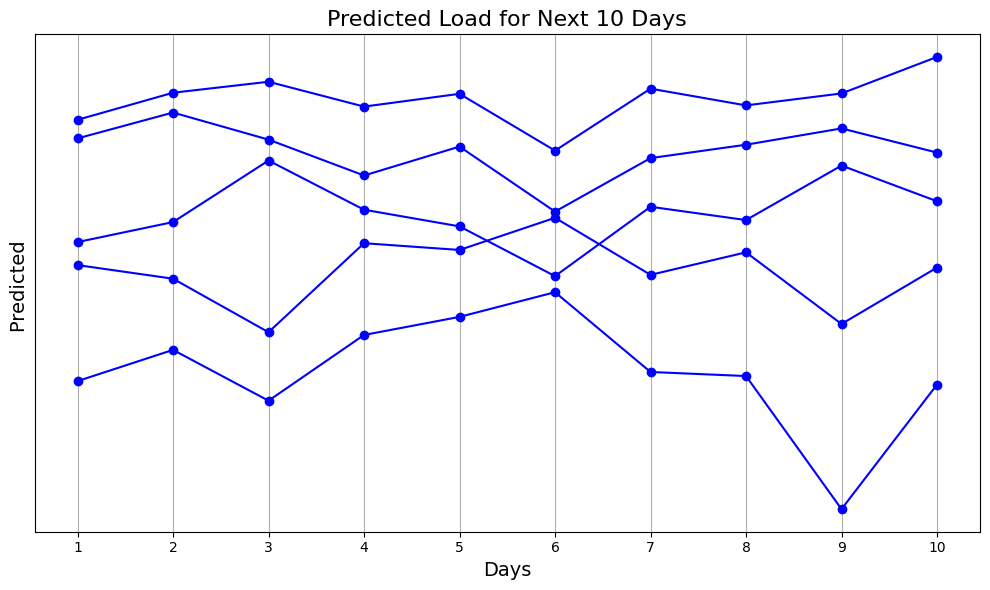

In [142]:
days = list(range(1, 11))
plt.figure(figsize=(10, 6))
plt.plot(days, train_predictions[:10], marker='o', linestyle='-', color='b')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Predicted ', fontsize=14)
plt.title('Predicted Load for Next 10 Days', fontsize=16)
plt.xticks(days)
plt.yticks([])
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
train_predictions=from_pickle.predict(data)
train_predictions =scaler.inverse_transform(train_predictions.reshape(-1, 1)).ravel()

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [124]:
for i in range(11):
    print("Day",i,"is :",train_predictions[i])
    print()

Day 0 is : 28.454947

Day 1 is : 28.439253

Day 2 is : 28.382935

Day 3 is : 28.474758

Day 4 is : 28.479109

Day 5 is : 28.437504

Day 6 is : 28.451046

Day 7 is : 28.406246

Day 8 is : 28.485262

Day 9 is : 28.462944

Day 10 is : 28.434185



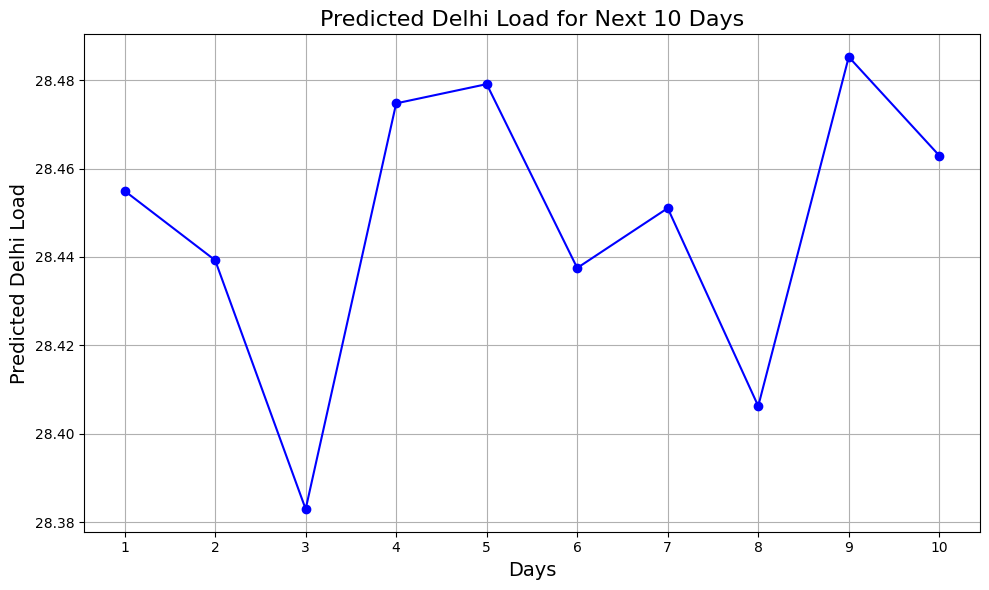

In [125]:
days = list(range(1, 11))
plt.figure(figsize=(10, 6))
plt.plot(days, train_predictions[:10], marker='o', linestyle='-', color='b')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Predicted Delhi Load', fontsize=14)
plt.title('Predicted Delhi Load for Next 10 Days', fontsize=16)
plt.xticks(days) 
plt.grid(True)
plt.tight_layout()
plt.show()